# OWC estimator v2
## well locations processed as is without any transformation

Добавить кроссвалидацию

blind test

In [97]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, date
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import pylab
from pylab import rcParams

Исходные данные

In [98]:
data_path = '../data/ps_owc/df.xlsx'
df_train = pd.read_excel(data_path, sheet_name='train2')
df_test = pd.read_excel(data_path, sheet_name='test2')

Выборка разбита на тренировочный и тестовый сеты

In [99]:
df_train

,Well,ST,Cum prod,Days,In prod,Q oil,wct,Top perf,Bottom perf,x,y
0,67db,0,1193324,8096,1,978.804120,14.359520,-2327.00,-2362.00,511800.026,5628729.313
1,47db,0,1385332,9039,1,276.656310,7.812500,-2332.30,-2356.30,511736.144,5628907.637
2,68db,0,297912,2830,0,0.000000,100.000000,-2471.29,-2482.25,511786.343,5628440.921
3,64db,0,839156,7701,0,0.000000,100.000000,-2357.90,-2424.90,511935.750,5629329.419
4,64bs,1,46074,943,1,724.129470,44.824001,-2335.00,-2357.00,511993.873,5629142.471
5,75db,0,913232,7366,0,0.000000,100.000000,-2367.50,-2371.50,512163.491,5629551.407
6,Plat-2,0,1311418,8066,1,676.000000,82.300942,-2316.00,-2331.50,512292.849,5629840.896
7,Plat-6,0,409876,7305,0,0.000000,100.000000,-2317.70,-2339.10,512344.002,5630441.182
8,Mak-102,0,368413,8917,1,259.725098,87.058953,-2332.13,-2339.12,512628.418,5631054.952
9,63db,0,64411,2191,0,0.000000,100.000000,-2501.81,-2540.18,512798.074,5630896.973


In [100]:
df_test

,Well,ST,Cum prod,Days,In prod,Q oil,wct,Top perf,Bottom perf,x,y
0,Plat-15,0,947441,7609,0,0,100.0,-2315.05,-2326.05,512352.49700,5.630100e+06
1,Plat-8,0,672904,7578,1,746,81.4,-2321.98,-2386.96,512383.26500,5.630703e+06
2,Plat-8ST,1,0,0,1,0,0.0,-2319.00,-2350.00,512339.76734,5.630541e+06
3,Plat-15ST,1,0,0,0,0,0.0,-2314.00,-2384.00,512138.00000,5.630185e+06


Возможность смены кровли Ливенского горизонта в точке вскрытия скважины

Исходный параметр = -2314 м а.о.

Чувствительность модели к это му параметру низкая. Изменение кровли пласта в разумных пределах (до 100 м) не приводит к значимому изменению обводённсти.

In [101]:
#df_test.at[3,'Top perf']= -2300

В тестовой выборке удаляем имя скважины и целевой (предсказываемый) признак

In [102]:
x_test = df_test.drop(['Well', 'wct'], axis=1)
y_test = df_test['wct']
x_test

,ST,Cum prod,Days,In prod,Q oil,Top perf,Bottom perf,x,y
0,0,947441,7609,0,0,-2315.05,-2326.05,512352.49700,5.630100e+06
1,0,672904,7578,1,746,-2321.98,-2386.96,512383.26500,5.630703e+06
2,1,0,0,1,0,-2319.00,-2350.00,512339.76734,5.630541e+06
3,1,0,0,0,0,-2314.00,-2384.00,512138.00000,5.630185e+06


Удаляем категорийный признак (имя скважины) и создаём целевой датасет и датасет признаков.

In [103]:
x = df_train.drop(['Well', 'wct'], axis=1)
y = df_train['wct']
x

,ST,Cum prod,Days,In prod,Q oil,Top perf,Bottom perf,x,y
0,0,1193324,8096,1,978.804120,-2327.00,-2362.00,511800.026,5628729.313
1,0,1385332,9039,1,276.656310,-2332.30,-2356.30,511736.144,5628907.637
2,0,297912,2830,0,0.000000,-2471.29,-2482.25,511786.343,5628440.921
3,0,839156,7701,0,0.000000,-2357.90,-2424.90,511935.750,5629329.419
4,1,46074,943,1,724.129470,-2335.00,-2357.00,511993.873,5629142.471
5,0,913232,7366,0,0.000000,-2367.50,-2371.50,512163.491,5629551.407
6,0,1311418,8066,1,676.000000,-2316.00,-2331.50,512292.849,5629840.896
7,0,409876,7305,0,0.000000,-2317.70,-2339.10,512344.002,5630441.182
8,0,368413,8917,1,259.725098,-2332.13,-2339.12,512628.418,5631054.952
9,0,64411,2191,0,0.000000,-2501.81,-2540.18,512798.074,5630896.973


Создаём скейлер для масштабирования данных

обучаем скейлер на тренировочных данных и масштабируем их

масштабируем тестовые данные на обученном скейлере

создаём модель LinearRegression / RandomForestRegressor

тренируем модель

рассчитываем обводнённость по тестовой выборке

рассчитываем обводнённость по тренировочной выборке

оцениваем качество модели: считаем коэффициенты R^2 по тестовым и тренировочным выборкам

In [104]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x)

x_test = scaler.transform(df_test.drop(['Well', 'wct'], axis=1))

model = RandomForestRegressor(random_state=42, max_depth=14)
model.fit(x_train, y)

y_pred = model.predict(x_test)

y_pred_train = model.predict(x_train)

r2_train = r2(y, y_pred_train)
mae_train = mae(y, y_pred_train)
mse_train = mse(y, y_pred_train)
print(f'R2 train: {r2_train.round(4)}')
print(f'MAE train: {mae_train.round(4)}')
print(f'MSE train: {mse_train.round(4)}')

r2_test = r2(y_test, y_pred)
mae_test = mae(y_test, y_pred)
mse_test = mse(y_test, y_pred)
print(f'R2 test: {r2_test.round(4)}')
print(f'MAE test: {mae_test.round(4)}')
print(f'MSE test: {mse_test.round(4)}')

model

R2 train: 0.8495
MAE train: 8.8316
MSE train: 170.1743
R2 test: -0.7881
MAE test: 47.0698
MSE test: 3754.692


RandomForestRegressor(max_depth=14, random_state=42)

In [105]:
df_y_test = pd.DataFrame({'Well': df_test['Well'], 
                          'wct predicted, %': y_pred.round(1), 
                          'wct actual, %': y_test.round(1)})
df_y_test

,Well,"wct predicted, %","wct actual, %"
0,Plat-15,96.7,100.0
1,Plat-8,68.7,81.4
2,Plat-8ST,84.3,0.0
3,Plat-15ST,88.0,0.0


In [106]:
df_y_train = pd.DataFrame({'Well': df_train['Well'], 
                           'wct predicted, %': y_pred_train.round(1), 
                           'wct actual, %': y.round(1)})
df_y_train

,Well,"wct predicted, %","wct actual, %"
0,67db,34.9,14.4
1,47db,41.1,7.8
2,68db,85.9,100.0
3,64db,92.6,100.0
4,64bs,56.9,44.8
5,75db,99.1,100.0
6,Plat-2,72.8,82.3
7,Plat-6,97.9,100.0
8,Mak-102,83.3,87.1
9,63db,98.6,100.0


In [107]:
model.feature_importances_
feature_importances = pd.DataFrame()
feature_importances['importance'] = model.feature_importances_
feature_importances['feature_name'] = x.columns.tolist()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,importance,feature_name
4,0.363849,Q oil
2,0.164947,Days
8,0.114511,y
7,0.096487,x
1,0.092135,Cum prod
0,0.079849,ST
3,0.046274,In prod
5,0.032486,Top perf
6,0.009462,Bottom perf


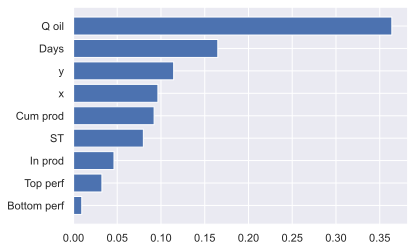

In [108]:
feature_importances = feature_importances.sort_values(by='importance', ascending=True)
height = feature_importances['importance']
bars = feature_importances['feature_name']
y_pos = np.arange(len(bars))
# Create horizontal bars
plt.barh(y_pos, height)
 # Create names on the y-axis
plt.yticks(y_pos, bars)
plt.show()

R2:	0.849
MAE:	9.0
MSE:	170.0


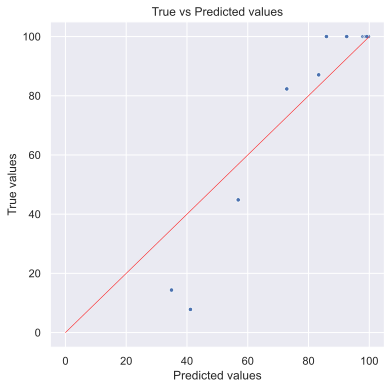

R2:	-0.788
MAE:	47.0
MSE:	3755.0


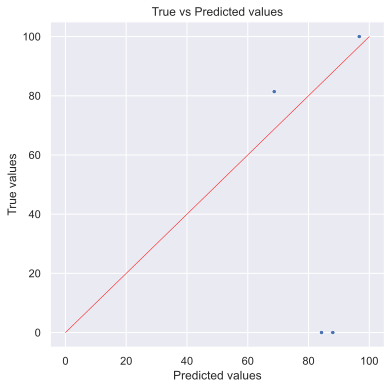

In [109]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 0)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 0))) 
    plt.figure(figsize=(6,6))
    sns.set(style="darkgrid")
    sns.scatterplot(x=pred_values, y=true_values, s=20)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    sns.lineplot(x=[0, 100], y=[0, 100], color='red', linewidth=0.5)
    plt.title('True vs Predicted values')
    plt.ylim(-5, 105)
    plt.xlim(-5, 105)
    plt.show()

evaluate_preds(y.values.flatten(), y_pred_train.flatten())
evaluate_preds(y_test.values.flatten(), y_pred.flatten())